In [40]:
import numpy as np
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer

In [41]:
def mat_det(a, b, c):
    """
    Obliczanie wyznacznika macierzy 3x3 bez użycia funkcji bibliotecznych
    :param a: krotka współrzędnych (x, y) pierwszego punktu tworzącego naszą prostą
    :param b: krotka współrzędnych (x, y) drugiego punktu tworzącego naszą prostą
    :param c: krotka współrzędnych (x, y) punktu, którego położenie względem prostej chcemy znaleźć
    :return: wartość wyznacznika macierzy
    """
    ax,ay = a
    bx,by = b
    cx,cy = c
    return (bx-ax)*(cy-by)-(by-ay)*(cx-bx)

In [42]:
def generate_uniform_points(left, right, n = 10 ** 5):
    """
    Funkcja generuje równomiernie n punktów na kwadratowym obszarze od left do right (jednakowo na osi y) o współrzędnych rzeczywistych
    :param left:  lewy kraniec przedziału
    :param right: prawy kraniec przedziału
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych np. [(x1, y1), (x2, y2), ... (xn, yn)]
    """
    points = []
    for i in range(n):
        points.append(np.random.uniform(left, right, 2))
    return points

In [43]:
def generate_collinear_points(a, b, n=100):
    """
    Funkcja generuje równomiernie n współliniowych punktów leżących na odcinku ab pomiędzy punktami a i b
    :param a: krotka współrzędnych oznaczająca początek odcinka
    :param b: krotka współrzędnych oznaczająca koniec odcinka
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych
    """
    x1,y1 = a
    x2, y2 = b
    v = [x2-x1, y2-y1]
    x = lambda t: x1 + t*v[0]
    y = lambda t: y1 + t*v[1]
    P = lambda t: (x(t), y(t))
    points = []
    for i in range(n):
        t = np.random.uniform(0,1)
        points.append(P(t))
    return points

In [44]:
def drawPoints(points,lines=[]):
    vis = Visualizer()
    vis.add_grid()
    vis.add_point(points)
    if len(lines) > 0:
        vis.add_polygon(lines,alpha=0.7)
    vis.show()

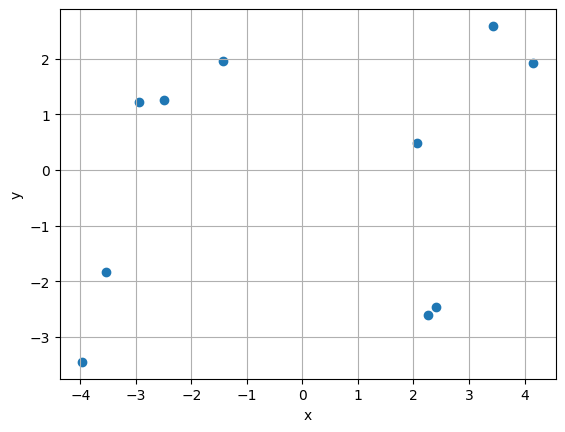

In [45]:
points = generate_uniform_points(-5, 5, n=10)
drawPoints(points)

## Algorytm Jarvisa
wykorzystywany do znajdywania otoczki wypułkłej w czasie nk

Algorytm Jarvisa - kroki
1. Wybierz punkt którego y jest najmniejszy - p0
2. Znajdź punkt p który tworzy najmniejszy kąt z miedzy prostą p-p0 a osią OX -  zrobimy to za pomocą funkcji "orient"
3. Dodaj punkt

In [46]:
def orient(a,b,c,eps=1e-8):
    """
    Celem funkcji jest stworzenie porządku dla punktów. Sprawdza czy mniejszy kąt względem osi OX tworzy prosta ab czy ac
    """
    det = mat_det(a,b,c)
    if abs(det) <= eps:
        return 0
    if det < eps:
        return 1
    return -1

In [47]:
def find_p0(points):
    p0_idx = 0
    p0 = points[0]
    for i in range(len(points)):
        if points[i][1] < p0[1]:
            p0 = points[i]
            p0_idx = i
    return p0_idx

In [48]:
def calc_distance(a,b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [49]:
def find_next(points,a0_idx):
    next_p = (a0_idx+1)%len(points)
    next = points[next_p]
    found_next_not_on_line = False 
    a0 = points[a0_idx]
    sameline_idx = None
    sameline_dist = 0
    for i in range(len(points)):
        res = orient(a0,next,points[i])
        if res == 0:
            if sameline_idx is None:
                sameline_idx = i
                sameline_dist = calc_distance(a0,points[i])
            else:
                curr_dist = calc_distance(a0,points[i])
                if curr_dist > sameline_dist:
                    sameline_idx = i
                    sameline_dist = curr_dist
                
        elif res > 0:
            found_next_not_on_line = True
            next = points[i]
            next_p = i
    if not found_next_not_on_line:
        next_p = sameline_idx
    return next_p

In [50]:
def Jarvis(points):
    # points = [tuple(p) for p in points]
    p0_idx = find_p0(points)
    a0_idx = p0_idx
    sol = [points[a0_idx]]
    while True:
        next_idx = find_next(points,a0_idx)
        a0_idx = next_idx
        if next_idx == p0_idx:
            break
        sol.append(points[next_idx])

    return sol


### Testing...

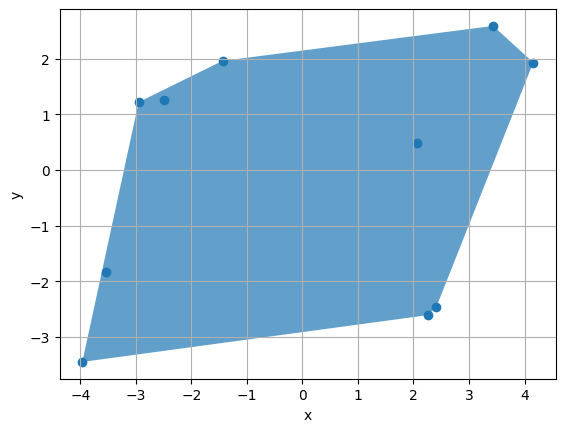

In [51]:
convex_hull = Jarvis(points)
drawPoints(points,convex_hull)

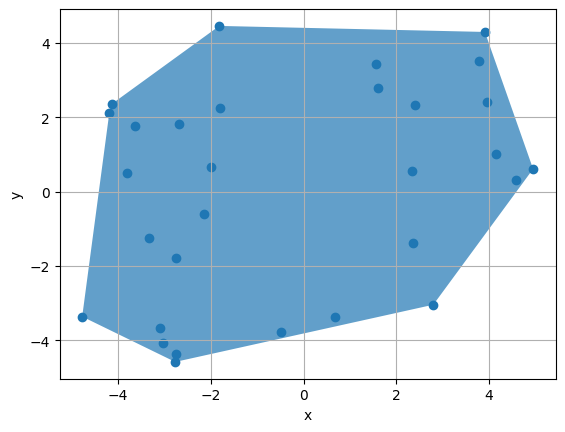

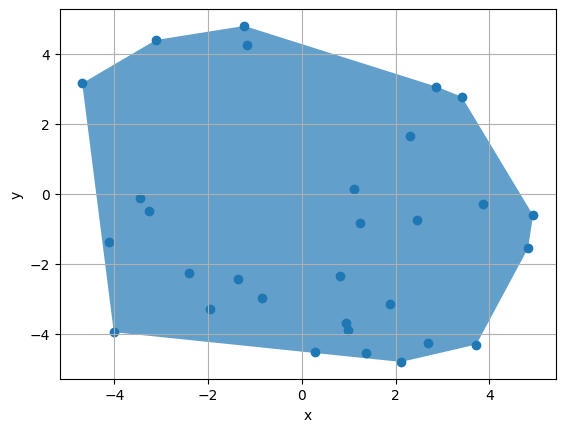

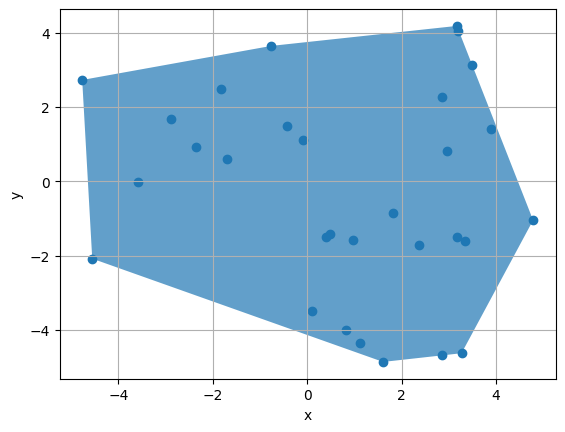

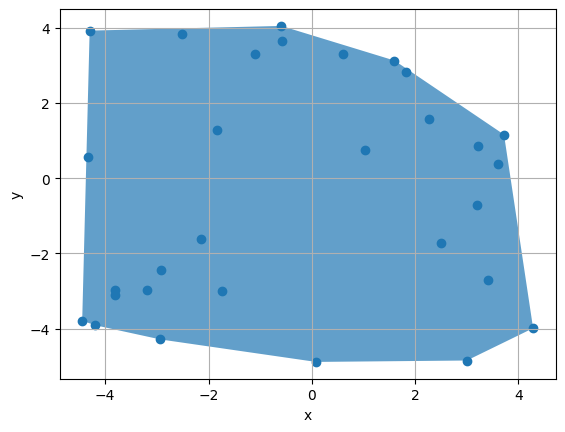

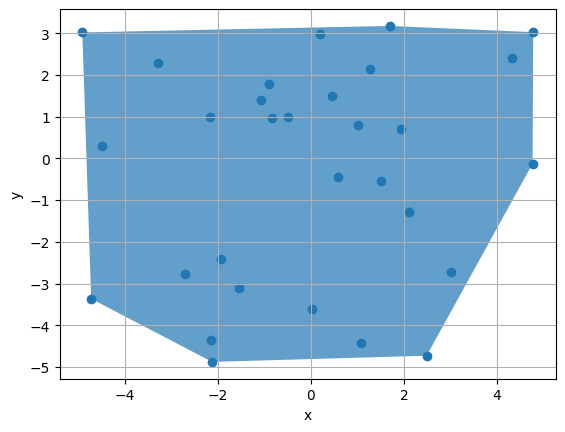

In [52]:
for p in range(5):
    points = generate_uniform_points(-5,5,30)
    drawPoints(points,Jarvis(points))

4 punkty na lini

3 punkty w otoczce
[(-0.9714109621939984, -0.9571164432909975), (1, 0), (0.7416117981716523, 1.6124176972574786)]


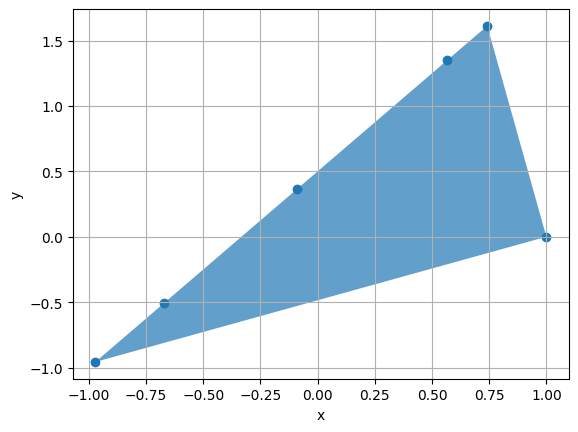

In [53]:
points_b = generate_collinear_points((-1,-1), (1,2),5)
points_b.append((1,0))
convex_hull = Jarvis(points_b)
print(f"{len(convex_hull)} punkty w otoczce")
print(convex_hull)
drawPoints(points_b,convex_hull)


### Algorytm Grahama

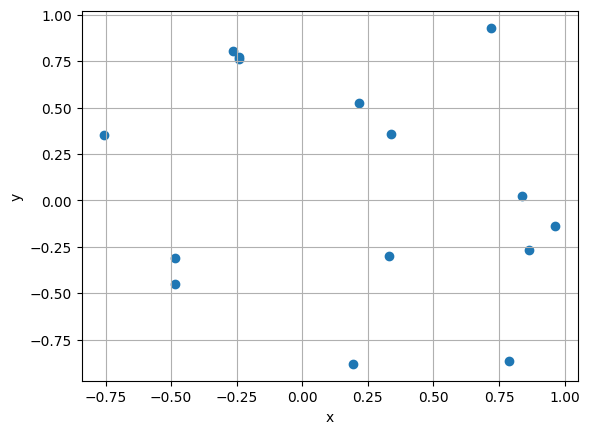

In [54]:
points = generate_uniform_points(-1,1,15)
drawPoints(points)

In [55]:
def sort_by_angle(points):
    points_copy = [tuple(p) for p in points]
    a0 = min(points_copy,key=lambda x:x[1])
    sorted_points = [a0]
    points_copy.remove(a0)
    while len(points_copy) > 0:
        lowest = points_copy[0]
        for p in points_copy:
            if orient(a0,lowest,p) > 0:
                lowest = p
        sorted_points.append(lowest)
        points_copy.remove(lowest)
    return sorted_points

In [1]:
from functools import cmp_to_key
def sort_by_angleV2(points):
    a0_idx = 0
    a0 = points[0]
    # for i in range(1,len(points)):
    #     if a0[1] > points[i][1]:
    #         a0 = points[i]
    #         a0_idx = i
    # a0_idx = points.index(min(points,key=lambda x: x[1]))
    a0_idx = np.where(points == np.min(points,axis=1))[0][0]
    points[0],points[a0_idx] = points[a0_idx],points[0] 
    a0 = points[0]
    cmp = lambda x,y: orient(a0,x,y)
    return [a0] + sorted(points[1:],key=cmp_to_key(cmp))

In [57]:
def filter_on_same_line(points):
    result = []
    i = 0
    j = 2
    while j < len(points):
        if orient(points[i],points[j-1],points[j]) != 0:
            result += [np.min(points[i:j],axis=0)] + [np.max(points[i:j],axis=0)]
            i=j-1
        j += 1
    result += [np.min(points[i:j],axis=0)] + [np.max(points[i:j],axis=0)]
    return result

# tested = [np.array([1,1]),np.array([2,2]),np.array([3,3]),np.array([2,5]),np.array([1,7]),np.array([0,9])]
# print(filter_on_same_line(tested))

In [2]:
def graham(points):
    # sorted_points = sort_by_angle(points)
    sorted_points = sort_by_angleV2(points)
    # prepared_points = filter_on_same_line(sorted_points)
    prepared_points = sorted_points
    s = [*prepared_points[:2]]
    for i in range(2,len(prepared_points)):
        p = prepared_points[i]
        while len(s) > 1 and orient(s[-2],s[-1],p) >= 0:
            s.pop()
        s.append(p)
    return s

### TESTING...

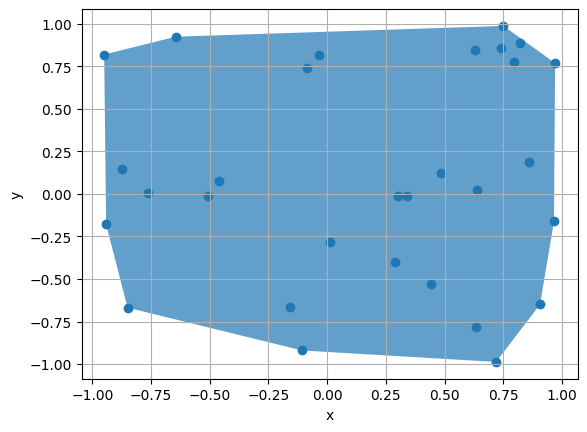

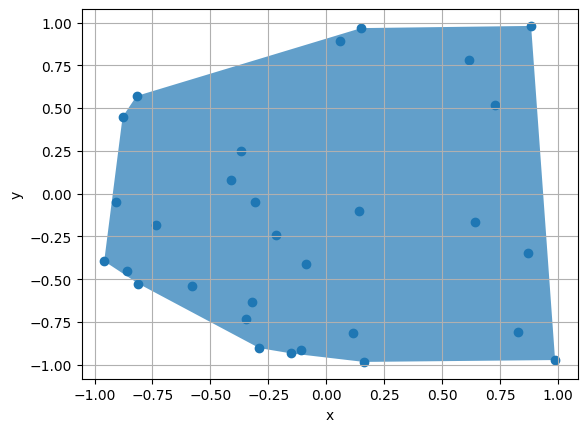

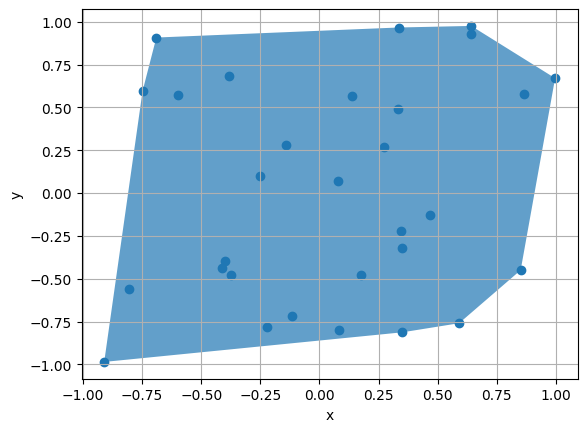

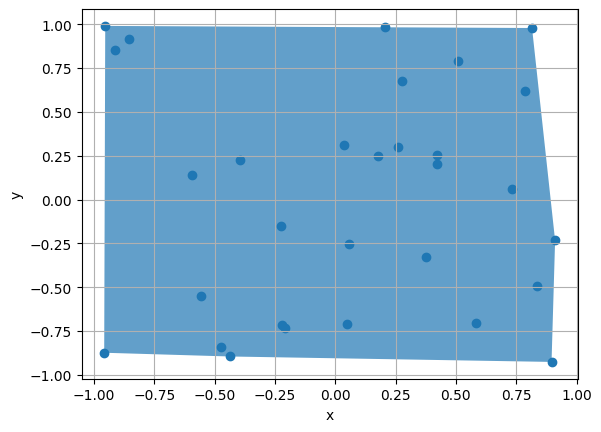

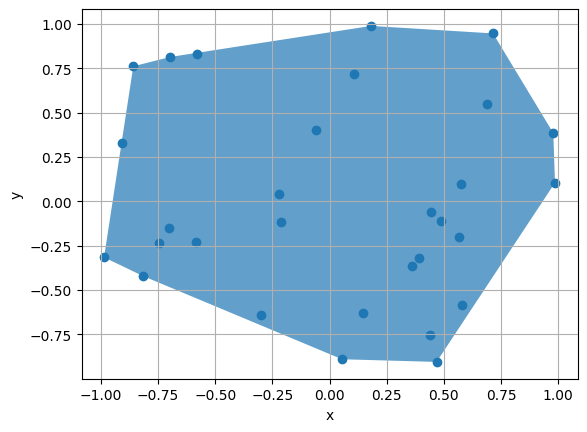

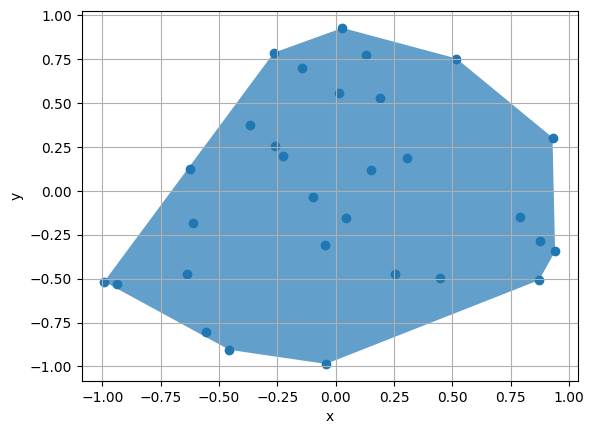

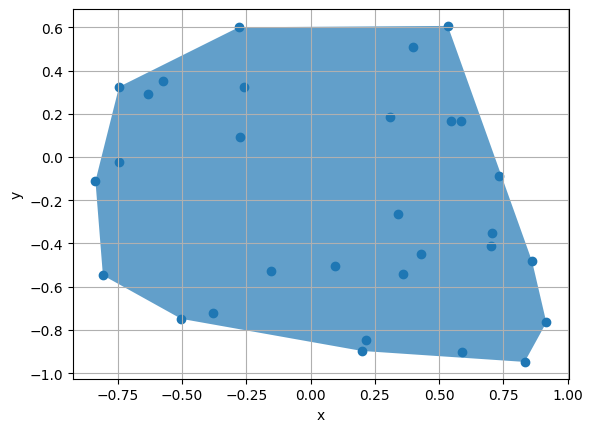

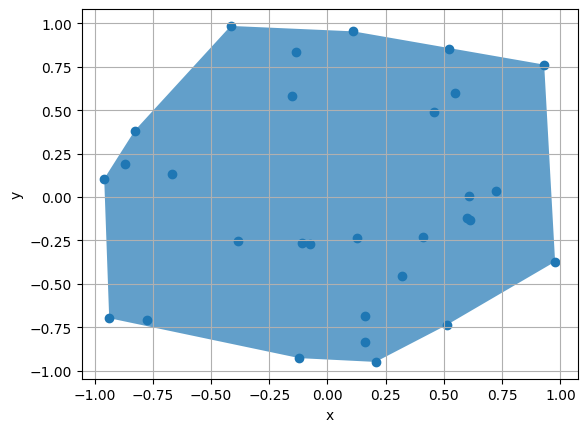

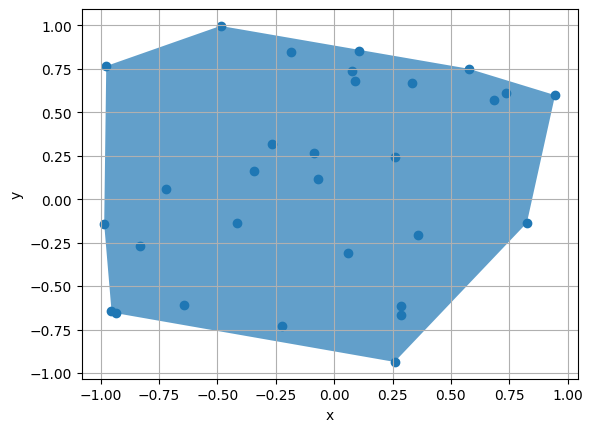

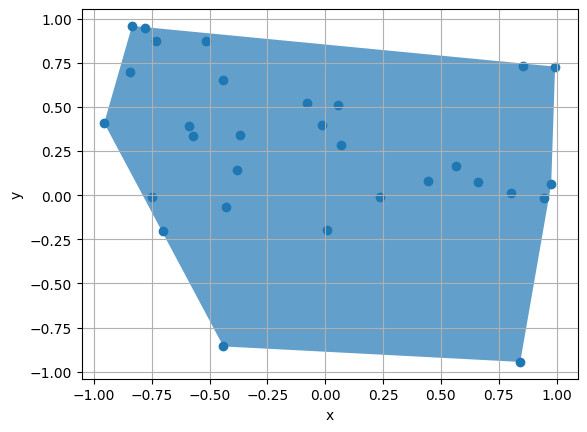

In [ ]:
for i in range(10):
    points = generate_uniform_points(-1,1,30)
    drawPoints(points,graham(points))

In [ ]:
for i in range(5):
    points_b = generate_collinear_points((1,2),(4,5),5)
    points_b.append((1,1))
    convex_hull = graham(points_b)
    print(len(convex_hull))
    drawPoints(points_b,convex_hull)